# TSE processing pipeline
This notebook presents the image pre-processing, multi-stack phase-only conductivity (MS-POC) and multi-stack phase-only convection-reaction (MS-POCR) tools used for reconstructing conductivity ($\sigma$) from TSE T2w stacks, demonstrated on a example subject from the dHCP cohort. 

**Acquisition information:** Imaging was carried out on a 3T ($f_0 = 128$ MHz) Philips Achieva scanner. Anatomical T2w multi-slice TSE images were acquired in sagittal and axial slice stacks with an in-plane resolution of $0.8 \times 0.8$ mm$^2$ and $1.6$ mm slices with an overlap of $0.8$ mm. Other parameters were: TR 12000 ms, TE 156 ms, SENSE factor 2.11 (axial) and 2.60 (sagittal). The TSE acquisitions were each reconstructed using a motion correction algorithm and then the transverse and sagittal images were fused into a single 3D volume using slice-to-volume (SVR) methods.

Part of nano-eptk package by Arnaud Boutillon (arnaud.boutillon@kcl.ac.uk).

## Python environment setting

In [1]:
import os
import sys
import json
import yaml
import itertools

base_dir = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(base_dir))

from utils.eprecon import *
from utils.preprocess import *
from utils.tools import *
from utils.plots import *

## 1. Image pre-processing 

### 1.a. Registration of TSE stacks to T2w volume
Images were rigdly aligned using MIRTK. (The original SVR rigid transforms were not available.) We registered available dHCP tissue segmentation to define the brain region of interest (ROI) for conductivity reconstruction in TSE stacks.

In [2]:
# Number of TSE stacks
n = 3 

# Set directories
subj_dir = os.path.join(base_dir, "data", "dHCP", "example_subject")
tse_dir = os.path.join(subj_dir, "TSE")
deriv_dir = os.path.join(tse_dir, "derivatives")

# Set file path
T2w_path = os.path.join(tse_dir, "T2w.nii.gz")
T2w_dhcp_labels9_path = os.path.join(tse_dir, "dhcp_labels9.nii.gz")
T2w_mask_path = os.path.join(tse_dir, "mask.nii.gz")
stack_mag_paths = [os.path.join(tse_dir, f"stack{i}_mag.nii.gz") for i in range(n)]
stack_dhcp_labels9_paths = [os.path.join(deriv_dir, f"stack{i}_dhcp_labels9.nii.gz") for i in range(n)]
stack_mask_paths = [os.path.join(deriv_dir, f"stack{i}_mask.nii.gz") for i in range(n)]
stack_dof_paths = [os.path.join(deriv_dir, f"stack{i}_vol.dof") for i in range(n)]

# Iter over stacks
for i in range(n):
    # Register stack to volume
    mirtk_register(
        input_img1_path=T2w_path,
        input_img2_path=stack_mag_paths[i],
        output_dof_path=stack_dof_paths[i],
    )
    
    # Apply transform to mask and labels
    mirtk_transform_image(
        input_path=T2w_mask_path,
        input_target_path=stack_mag_paths[i],
        input_invdof_path=stack_dof_paths[i],
        output_path=stack_mask_paths[i],
        label=True,
    )
    mirtk_transform_image(
        input_path=T2w_dhcp_labels9_path,
        input_target_path=stack_mag_paths[i],
        input_invdof_path=stack_dof_paths[i],
        output_path=stack_dhcp_labels9_paths[i],
        label=True,
    )

### 1.b. Selection of axial and sagittal stacks with least slice-to-slice motion and creation of average magnitude, phase and mask
Slice-to-slice motion was quantified by a $z$-smoothness score defined as the STD of the slice-to-slice difference in the $z$ direction.

In [3]:
# Set file path
stack_pha_paths = [os.path.join(tse_dir, f"stack{i}_pha.nii.gz") for i in range(n)]
avg_mag_path = os.path.join(deriv_dir, "avg_mag.nii.gz")
avg_pha_path = os.path.join(deriv_dir, "avg_pha.nii.gz")
avg_mask_path = os.path.join(deriv_dir, "avg_mask.nii.gz")
avg_info_path = os.path.join(deriv_dir, "avg_info.json")

# Average stacks
average_stacks(
    input_mag_paths=stack_mag_paths,
    input_pha_paths=stack_pha_paths,
    input_mask_paths=stack_mask_paths,
    input_dof_paths=stack_dof_paths,
    output_mag_path=avg_mag_path,
    output_pha_path=avg_pha_path,
    output_mask_path=avg_mask_path,
    output_info_path=avg_info_path,
)

# Load stack selection information
info = json.load(open(avg_info_path))

# Display information
print(f"Axial stack index: {stack_mag_paths.index(info['axial']['mag'])}")
print(f"Sagittal stack index: {stack_mag_paths.index(info['sagittal']['mag'])}")

# Indexes of selected stacks
index = [stack_mag_paths.index(info[ornt]['mag']) for ornt in ["axial", "sagittal"]]

Axial stack index: 0
Sagittal stack index: 1


### 1.c. Flow void artefact correction on selected axial and sagittal phase stacks
Phase images presented discontinuities near the straight sinus due to MR signal loss associated with blood flow (i.e. flow void artefact). These discontinuities within the brain ROI lead to spurious oscillations in the conductivity maps reconstructed via finite difference schemes. To overcome this problem, we interpolated the image phase in these regions using radial basis function (RBF) thin-plate spline interpolation. 

In [4]:
# Set file path
stack_mag_paths = [stack_mag_paths[i] for i in index]
stack_pha_paths = [stack_pha_paths[i] for i in index]
stack_mask_paths = [stack_mask_paths[i] for i in index]
stack_pha_corr_paths = [os.path.join(deriv_dir, f"stack{i}_pha_corr.nii.gz") for i in index]
stack_mask_artefact_paths = [os.path.join(deriv_dir,f"stack{i}_mask_artefact.nii.gz") for i in index]

# Iter over stacks
for i in index:
    # Apply phase artefact correction
    correct_phase_artefact(
        input_pha_path=stack_pha_paths[i], 
        input_mask_path=stack_mask_paths[i], 
        output_pha_path=stack_pha_corr_paths[i],
        output_mask_artefact_path=stack_mask_artefact_paths[i],
        bsp_n=100,
        bsp_axes=[0,1]
    )

### 1.d. Creation of average mask artefacts from axial and sagittal stacks (for use in EPI processing pipeline) 
This average was used to initialize the phase correction in EPI images which presented a lower resolution and were more difficult to correct.

In [5]:
# Set file path
stack_dof_paths = [stack_dof_paths[i] for i in index]
avg_mask_artefact_path = os.path.join(deriv_dir,"avg_mask_artefact.nii.gz")

# Average mask artefact
average_phase_artefact_mask(
    input_mask_artefact_paths=stack_mask_artefact_paths,
    input_ref_mag_path=avg_mag_path,
    input_ref_mask_path=avg_mask_path,
    input_dof_paths=stack_dof_paths,
    output_mask_artefact_path=avg_mask_artefact_path,
)

## 2. Electrical properties reconstruction from TSE data

### 2.a. Brain conductivity reconstruction using the multi-stack phase-only conductivity (MS-POC) pipeline
We used the POC mapping technique based on the homogeneous Helmholtz equation to reconstruct the conductivity from the transceive phase image. As TSE data consisted of stacks acquired in both axial and sagittal slice directions, $\sigma$ maps were reconstructed separately for each, then registered and averaged to produce a single $\sigma$ prediction. The POC method relies on the local homogeneity assumption which states that the EPs are piecewise constant functions. Partial derivatives were expressed as finite central differences on the image grid. Due to slice-to-slice motion in the TSE phase images, we smoothed the phase images using a 2D slice-by-slice Gaussian filter and the Laplacian was computed only along the $x$ and $y$ axes. The estimated $\sigma$ map was then multiplied by a factor of $1.5$ to account for the missing through-slice derivative. This assumes that the effect of conductivity on the phase is isotropic. Finally, the predicted $\sigma$ maps were eroded using binary erosion to remove high $\sigma$ values at the boundary of the brain ROI.

**Pipeline paramaters:** Gaussian smoothing STD kernel $1.6$ mm, erosion radius $4.8$ mm.

In [6]:
# Set directories
ep_mspoc_dir = os.path.join(tse_dir, "ep_recon_mspoc")
deriv_mspoc_dir = os.path.join(tse_dir, "derivatives_mspoc")
config_dir = os.path.join(base_dir, "config")

# Set file path
stack_dhcp_labels9_paths = [stack_dhcp_labels9_paths[i] for i in index]
sig_path = os.path.join(ep_mspoc_dir, "sig.nii.gz")
mask_path = os.path.join(deriv_mspoc_dir, "mask.nii.gz")
stack_sig_paths = [os.path.join(deriv_mspoc_dir, f"stack{i}_sig.nii.gz") for i in index]
mask_eroded_path = os.path.join(deriv_mspoc_dir, "mask_eroded.nii.gz")
stack_mask_eroded_paths = [os.path.join(deriv_mspoc_dir, f"stack{i}_mask_eroded.nii.gz") for i in index]
sig_eroded_path = os.path.join(ep_mspoc_dir, "sig_eroded.nii.gz")
stack_sig_eroded_paths = [os.path.join(deriv_mspoc_dir, f"stack{i}_sig_eroded.nii.gz") for i in index]
ep_metrics_path = os.path.join(ep_mspoc_dir, "ep_metrics.json")
stack_ep_metrics_paths = [os.path.join(deriv_mspoc_dir, f"stack{i}_ep_metrics.json") for i in index]
config_path = os.path.join(config_dir, "dhcp_tse_mspoc.yaml")

# Load pipeline configuration
kwargs = yaml.safe_load(open(config_path))

# Run MS-POC pipeline
mspoc_pipeline(
    input_pha_paths=stack_pha_corr_paths,
    input_mask_paths=stack_mask_paths,
    input_dhcp_labels9_paths=stack_dhcp_labels9_paths,
    input_dof_paths=stack_dof_paths,
    input_ref_path=avg_mag_path,
    output_sig_path=sig_path,
    output_mask_path=mask_path,
    output_sig_paths=stack_sig_paths,
    output_mask_eroded_paths=stack_mask_eroded_paths,
    output_ep_metrics_paths=stack_ep_metrics_paths,
    output_sig_eroded_paths=stack_sig_eroded_paths,
    output_mask_eroded_path=mask_eroded_path,
    output_ep_metrics_path=ep_metrics_path,
    output_sig_eroded_path=sig_eroded_path,
    **kwargs,
)

#### Conductivity results

In [7]:
# Load conductivity metrics
ep_metrics = json.load(open(ep_metrics_path))

# Display metrics
print("TSE MS-POC reconstruction pipeline results:")
print(f"ROI conductivity: {ep_metrics['SIG']:.2f} ± {ep_metrics['SIG_std']:.2f} [S.m⁻¹]")
print(f"Brain conductivity (excluding CSF and ventricles): {ep_metrics['brain_SIG']:.2f} ± {ep_metrics['brain_SIG_std']:.2f} [S.m⁻¹]")
print(f"dGM conductivity: {ep_metrics['dGM_SIG']:.2f} ± {ep_metrics['dGM_SIG_std']:.2f} [S.m⁻¹]")
print(f"WM conductivity: {ep_metrics['WM_SIG']:.2f} ± {ep_metrics['WM_SIG_std']:.2f} [S.m⁻¹]")

TSE MS-POC reconstruction pipeline results:
ROI conductivity: 1.07 ± 3.24 [S.m⁻¹]
Brain conductivity (excluding CSF and ventricles): 1.10 ± 2.97 [S.m⁻¹]
dGM conductivity: 1.54 ± 3.68 [S.m⁻¹]
WM conductivity: 0.99 ± 2.14 [S.m⁻¹]


#### Diagram representation of the TSE MS-POC pipeline
The MS-POC method leads to spurious oscillations in the reconstructed conductivity at the tissue interface (i.e. where the homogeneity assumption is violated).

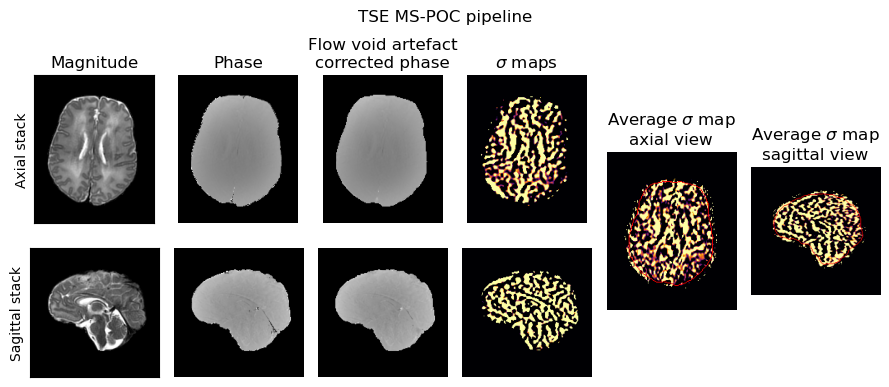

In [8]:
# Set file path
plot_dir = os.path.join(base_dir, "plots", "processing_pipelines")
plot_path = os.path.join(plot_dir, "tse_mspoc.png")

# Plotting
tse_pipeline_plot(
    input_mag_paths=stack_mag_paths,
    input_pha_paths=stack_pha_paths,
    input_pha_corr_paths=stack_pha_corr_paths,
    input_sig_paths=stack_sig_paths,
    input_mask_paths=stack_mask_paths,
    input_sig_path=sig_path,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    stack_view_info={"axial": {"stack_index": 0, "slice_index": 81}, "sagittal": {"stack_index": 1, "slice_index": 68}},
    output_plot_path=plot_path,
    view_info={"axial": {"slice_index": 114}, "sagittal": {"slice_index": 76}},
    mag_clim=[0, 25], 
    pha_clim=[-np.pi, np.pi],
    sig_clim=[0.6, 2.2],
    sig_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(9, 4),
    title="TSE MS-POC pipeline",
    save_imageio=True,
)

### 2.b. Brain conductivity reconstruction using the multi-stack phase-only convection-reaction (MS-POCR) pipeline
Due to the poor reconstruction performance of the MS-POC pipeline, we used the MS-POCR mapping technique based on the heterogeneous Helmholtz equation to reconstruct the conductivity from the transceive phase image. In our pipeline, the partial derivatives were expressed as finite central differences on the image grid. Considering all voxels within the brain mask, the PDE equation was reformulated as a large sparse linear optimization problem, and its solution was computed using the generalised minimal residual (GMRES) iterative method. The method incorporates a diffusion regularization constant to stabilizes the PDE solution without blurring the internal ROI significantly. Due to slice-to-slice motion in the TSE phase images, we smoothed the phase images using a 2D slice-by-slice Gaussian filter and partial derivatives were computed only along the $x$ and $y$ axes, while the regularisation term included all three spatial directions to ensure spatial cohesion in the predicted $\sigma$ map. The estimated $\sigma$ map was then multiplied by a factor of $1.5$ to account for the missing through-slice gradients and Laplacian. Conductivity  maps were reconstructed separately for each TSE stack, then registered and averaged to produce a single prediction. Finally, the predicted $\sigma$ map was eroded using binary erosion to remove high $\sigma$ values at the boundary of the brain ROI due to unknown boundary conditions in the PDE.

**Pipeline parameters:** Gaussian smoothing STD kernel $1.6$ mm, diffusion regularisation weight $0.05$, erosion radius $4.8$ mm.

In [9]:
# Set directories
ep_mspocr_dir = os.path.join(tse_dir, "ep_recon_mspocr")
deriv_mspocr_dir = os.path.join(tse_dir, "derivatives_mspocr")

# Set file path
stack_dhcp_labels9_paths = [stack_dhcp_labels9_paths[i] for i in index]
sig_path = os.path.join(ep_mspocr_dir, "sig.nii.gz")
mask_path = os.path.join(deriv_mspocr_dir, "mask.nii.gz")
stack_sig_paths = [os.path.join(deriv_mspocr_dir, f"stack{i}_sig.nii.gz") for i in index]
mask_eroded_path = os.path.join(deriv_mspocr_dir, "mask_eroded.nii.gz")
stack_mask_eroded_paths = [os.path.join(deriv_mspocr_dir, f"stack{i}_mask_eroded.nii.gz") for i in index]
sig_eroded_path = os.path.join(ep_mspocr_dir, "sig_eroded.nii.gz")
stack_sig_eroded_paths = [os.path.join(deriv_mspocr_dir, f"stack{i}_sig_eroded.nii.gz") for i in index]
ep_metrics_path = os.path.join(ep_mspocr_dir, "ep_metrics.json")
stack_ep_metrics_paths = [os.path.join(deriv_mspocr_dir, f"stack{i}_ep_metrics.json") for i in index]
config_path = os.path.join(config_dir, "dhcp_tse_mspocr.yaml")

# Load pipeline configuration
kwargs = yaml.safe_load(open(config_path))

# Run MSPOCR pipeline
mspocr_pipeline(
    input_pha_paths=stack_pha_corr_paths,
    input_mask_paths=stack_mask_paths,
    input_dhcp_labels9_paths=stack_dhcp_labels9_paths,
    input_dof_paths=stack_dof_paths,
    input_ref_path=avg_mag_path,
    output_sig_path=sig_path,
    output_mask_path=mask_path,
    output_sig_paths=stack_sig_paths,
    output_mask_eroded_paths=stack_mask_eroded_paths,
    output_ep_metrics_paths=stack_ep_metrics_paths,
    output_sig_eroded_paths=stack_sig_eroded_paths,
    output_mask_eroded_path=mask_eroded_path,
    output_ep_metrics_path=ep_metrics_path,
    output_sig_eroded_path=sig_eroded_path,
    **kwargs,
)

#### Conductivity results

In [10]:
# Load conductivity metrics
ep_metrics = json.load(open(ep_metrics_path))

# Display metrics
print("TSE MS-POCR reconstruction pipeline results:")
print(f"ROI conductivity: {ep_metrics['SIG']:.2f} ± {ep_metrics['SIG_std']:.2f} [S.m⁻¹]")
print(f"Brain conductivity (excluding CSF and ventricles): {ep_metrics['brain_SIG']:.2f} ± {ep_metrics['brain_SIG_std']:.2f} [S.m⁻¹]")
print(f"dGM conductivity: {ep_metrics['dGM_SIG']:.2f} ± {ep_metrics['dGM_SIG_std']:.2f} [S.m⁻¹]")
print(f"WM conductivity: {ep_metrics['WM_SIG']:.2f} ± {ep_metrics['WM_SIG_std']:.2f} [S.m⁻¹]")

TSE MS-POCR reconstruction pipeline results:
ROI conductivity: 1.26 ± 0.24 [S.m⁻¹]
Brain conductivity (excluding CSF and ventricles): 1.27 ± 0.23 [S.m⁻¹]
dGM conductivity: 1.09 ± 0.30 [S.m⁻¹]
WM conductivity: 1.26 ± 0.19 [S.m⁻¹]


#### Diagram representation of the TSE MS-POCR pipeline
The MS-POCR pipeline provide more robust extraction of brain conductivity than the MS-POC method.

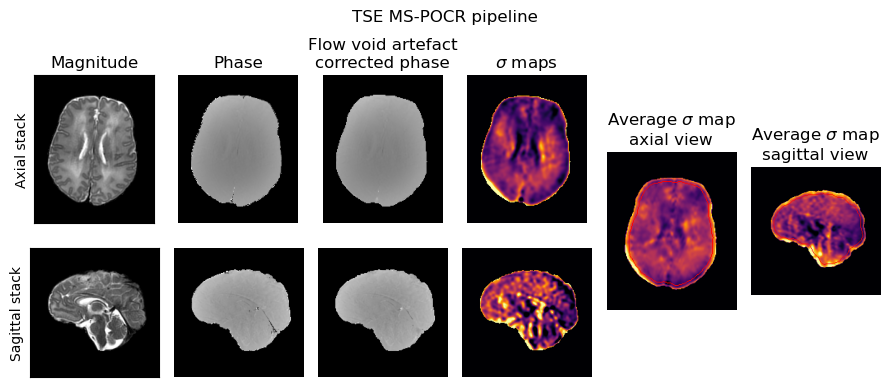

In [11]:
# Set file path
plot_path = os.path.join(plot_dir, "tse_mspocr.png")

# Plotting
tse_pipeline_plot(
    input_mag_paths=stack_mag_paths,
    input_pha_paths=stack_pha_paths,
    input_pha_corr_paths=stack_pha_corr_paths,
    input_sig_paths=stack_sig_paths,
    input_mask_paths=stack_mask_paths,
    input_sig_path=sig_path,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    stack_view_info={"axial": {"stack_index": 0, "slice_index": 81}, "sagittal": {"stack_index": 1, "slice_index": 68}},
    output_plot_path=plot_path,
    view_info={"axial": {"slice_index": 114}, "sagittal": {"slice_index": 76}},
    mag_clim=[0, 25], 
    pha_clim=[-np.pi, np.pi],
    sig_clim=[0.6, 2.2],
    sig_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(9, 4),
    title="TSE MS-POCR pipeline",
    save_imageio=True,
)

## 3. Impact of MS-POCR pipeline parameters on electrical properties reconstruction

### 3.a Tuning of Gaussian smoothing (*$\Sigma$*) and diffusion regularization weight (*c*)
Smoothing is a typical pre-processing step in all EPT pipelines to improve the robustness of the EPs reconstruction, as derivatives involved in Helmholtz equation are very sensitive to noise in the high frequency region of the Fourier spectrum. However, this also exacerbates boundary errors; therefore, there is a trade-off between signal to noise ratio (SNR) and tissue contrast in EPs maps. Similarly, the amount of regularisation in the MS-POCR pipeline is controlled by the diffusion constant $c$, and there is there is a trade-off between the accuracy and the stability of the solution when choosing its value.

In [12]:
# Set directory
tuning_dir = os.path.join(tse_dir, "ep_recon_mspocr_tuning")

# Set parameters grid
gs_sigmas = [0.4, 0.8, 1.2, 1.6, 2]
diff_reg_ws = [0.01, 0.05, 0.1]
sig_paths = []

# Iter over parameters
for i, (gs_sigma, diff_reg_w) in enumerate(itertools.product(gs_sigmas, diff_reg_ws)):

    # Set file path
    sig_path = os.path.join(tuning_dir, f"sig_0_{i}.nii.gz")
    sig_paths += [sig_path]

    # Set parameters
    kwargs = yaml.safe_load(open(config_path))
    kwargs["gs_sigma"] = gs_sigma
    kwargs["diff_reg_w"] = diff_reg_w

    # Run MSPOCR pipeline
    mspocr_pipeline(
        input_pha_paths=stack_pha_corr_paths,
        input_mask_paths=stack_mask_paths,
        input_dof_paths=stack_dof_paths,
        input_ref_path=avg_mag_path,
        output_sig_path=sig_path,
        **kwargs,
    )

# Reshape array
m, k = len(gs_sigmas), len(diff_reg_ws)
sig_paths = [sig_paths[i*k:(i+1)*k] for i in range(m)]

#### Parameter tuning plot

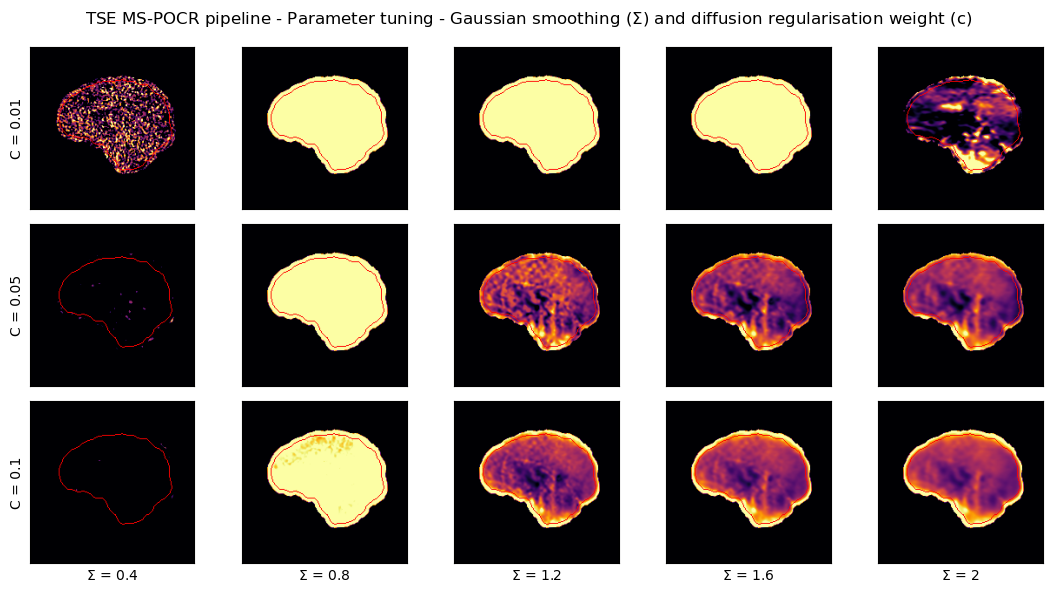

In [13]:
# Set file path
plot_path = os.path.join(plot_dir, "tse_mspocr_tuning_a.png")
gs_sigma_labels = [f"{gs_sigma:.4f} mm" for gs_sigma in gs_sigmas]

# Plotting
parameter_tuning_plot(
    input_sig_paths=sig_paths,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=76,
    ornt="sagittal",
    param_info={r"$\sigma$": gs_sigmas, "c": diff_reg_ws},
    ep_clim=[0.6, 2.2],
    ep_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(11, 6),
    title=r"TSE MS-POCR pipeline - Parameter tuning - Gaussian smoothing ($\Sigma$) and diffusion regularisation weight (c)",
    save_imageio=True,
)

### 3.b. Effect of 2D vs. 3D Gaussian smoothing and diffusion regularisation

In [14]:
# Set parameters grid
gs_axes = [[0,1], [0,1,2]]
diff_reg_axes = [[0,1], [0,1,2]]
sig_paths = []

# Iter over parameters
for i, (gs_ax, diff_reg_ax) in enumerate(itertools.product(gs_axes, diff_reg_axes)):
    # Set file path
    sig_path = os.path.join(tuning_dir, f"sig_1_{i}.nii.gz")
    sig_paths += [sig_path]

    # Set parameters
    kwargs = yaml.safe_load(open(config_path))
    kwargs["gs_axes"] = gs_ax
    kwargs["diff_reg_axes"] = diff_reg_ax

    # Run POCR pipeline
    mspocr_pipeline(
        input_pha_paths=stack_pha_corr_paths,
        input_mask_paths=stack_mask_paths,
        input_dof_paths=stack_dof_paths,
        input_ref_path=avg_mag_path,
        output_sig_path=sig_path,
        **kwargs,
    )

# Reshape array
m, k = len(gs_axes), len(diff_reg_axes)
sig_paths = [sig_paths[i*k:(i+1)*k] for i in range(m)]

#### Parameter tuning plot

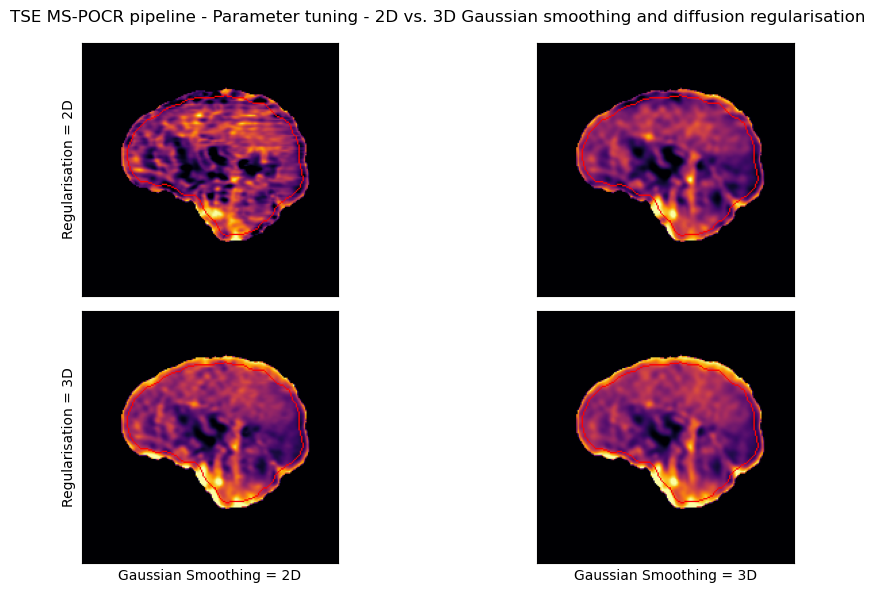

In [15]:
# Set file path
plot_path = os.path.join(plot_dir, "tse_mspocr_tuning_b.png")

# Plotting
parameter_tuning_plot(
    input_sig_paths=sig_paths,
    input_mask_path=mask_path,
    input_mask_eroded_path=mask_eroded_path,
    output_plot_path=plot_path,
    slice_index=76,
    ornt="sagittal",
    param_info={"Gaussian smoothing": ["2D", "3D"], "Regularisation": ["2D", "3D"]},
    ep_clim=[0.6, 2.2],
    ep_cmap="inferno",
    outline_c=(1,0,0),
    figsize=(11, 6),
    title="TSE MS-POCR pipeline - Parameter tuning - 2D vs. 3D Gaussian smoothing and diffusion regularisation",
    save_imageio=True,
)

## 4. Image post-processing

### 4.a. Registration of MS-POCR conductivity map to dHCP atlas (for use in conductivity atlas construction and voxel-wise analysis)
Conductivity map was rigidly aligned to T2w subject space using MIRTK and non-linearly transformed to the atlas space using FSL. We used the available dHCP diffeomorphisms computed from anatomical T2w images as warp.

In [16]:
# Set directory
atlas_dir = os.path.join(base_dir, "data", "dHCP", "atlas", "anat")

# Set file path
sig_path = os.path.join(ep_mspocr_dir, "sig.nii.gz")
sig_in_T2w_path = os.path.join(deriv_mspocr_dir, "sig_in_T2w.nii.gz")
atlas_path = os.path.join(atlas_dir, "week40_T2w.nii.gz")
warp_path = os.path.join(subj_dir, "xfm", "T2w_to_extdhcp40wk.nii.gz")
sig_in_atlas_path = os.path.join(deriv_mspocr_dir, "sig_in_extdhcp40wk.nii.gz")
sig_in_atlas_res15mm_path = os.path.join(deriv_mspocr_dir, "sig_in_extdhcp40wk_res15mm.nii.gz")

# Rigidly transform to subject T2w space
mirtk_transform_image(
    input_path=sig_path,
    output_path=sig_in_T2w_path,
    input_target_path=T2w_path,
)

# Non-linearly warp to dHCP week 40 atlas
fsl_apply_warp(
    input_img_path=sig_in_T2w_path,
    input_target_path=atlas_path,
    input_warp_path=warp_path,
    output_img_path=sig_in_atlas_path,
)

# Resample to 1.5 mm for voxel-wise analysis
mirtk_resample_image(
    input_path=sig_in_atlas_path,
    output_path=sig_in_atlas_res15mm_path,
    size=[1.5, 1.5, 1.5],
    interp="Linear with padding",
)

#### Conductivity map in atlas space

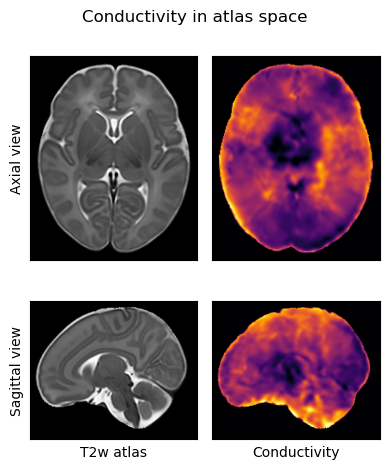

In [17]:
# Set file path
plot_path = os.path.join(plot_dir, "tse_mopcr_in_atlas.png")
mask_path = os.path.join(atlas_dir, "week40_mask.nii.gz")

# Plotting
covariates_plot(
    input_cov_paths=[atlas_path, sig_in_atlas_path],
    input_cov_labels=["T2w atlas", "Conductivity"],
    input_mask_path=mask_path,
    output_plot_path=plot_path,
    view_info={"axial": { "slice_index": 98}, "sagittal": {"slice_index": 107}},
    ep_cmap=[[None, None], ["inferno", "inferno"]],
    ep_clim=[[[0.0, 95.0], [0.0, 95.0]], [[0.6, 2.2], [0.6, 2.2]]],
    figsize=(4, 5),
    title="Conductivity in atlas space",
    save_imageio=True,
)